In [1]:
# Distribution ✨ jit ❇ Demo 💪 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# %load_ext autoreload
# %autoreload 2
# %env "WANDB_NOTEBOOK_NAME" "run.ipynb" # ❕same as notebook
# from jax.config import config
# config.update('jax_disable_jit', True)


- 



In [ ]:
from jax import numpy as jnp
from jax import random as rnd

rng = rnd.PRNGKey(1)
n_b = 8

n_e = 1
n_u = 1
a = jnp.array([[0.0, 0.0, 0.0]])
r = rnd.normal(rng, (n_b, n_e, 3))

# Model 
def model(p, r):
    eye = jnp.eye(n_e)[..., None]
		
    if len(r.shape) == 1:  # jvp hack
        r = r.reshape(n_e, 3)
    
    ra = r[:, None, :] - a[None, :, :] # (r_i, a_j, 3)
    ra_len = jnp.linalg.norm(ra, axis=-1, keepdims=True) # (r_i, a_j, 1)
    
    rr = (r[None, :, :] - r[:, None, :])
    rr_len = jnp.linalg.norm(rr+eye,axis=-1,keepdims=True) * (jnp.ones((n_e,n_e,1))-eye)

    s_v = jnp.concatenate([ra, ra_len], axis=-1).reshape(n_e, -1)
    p_v = jnp.concatenate([rr, rr_len], axis=-1)
    
    ra_u, ra_d = ra.split([n_u,], axis=0)

    exp_u = jnp.linalg.norm(ra_u, axis=-1)[..., None]
    exp_d = jnp.linalg.norm(ra_d, axis=-1)[..., None]

    orb_u = (s_wu * (jnp.exp(-exp_u).sum(axis=1)))[None, ...]
    orb_d = (s_wd * (jnp.exp(-exp_d).sum(axis=1)))[None, ...]

    assert orb_u.shape == (1, n_u, n_u)

    log_psi, sgn = logdet_matmul([orb_u, orb_d])

    return log_psi, sgn
    

def logdet_matmul(xs):
	slogdets = [jnp.linalg.slogdet(x) for x in xs]
	
	sign_in, slogdet = functools.reduce(lambda a, b: (a[0] * b[0], a[1] + b[1]), slogdets)
	max_idx = jnp.argmax(slogdet)
	slogdet_max = slogdet[max_idx]
	det = sign_in * jnp.exp(slogdet-slogdet_max)
	
	result = jnp.sum(det)
	sign_out = jnp.sign(result)
	slog_out = jnp.log(jnp.abs(result)) + slogdet_max
	return slog_out, sign_out

def compute_pe(r, a, a_z):
	n_a = len(a)
	
	rr = jnp.expand_dims(r, -2) - jnp.expand_dims(r, -3)
	rr_len = jnp.linalg.norm(rr, axis=-1)
	pe_rr = jnp.tril(1./rr_len, k=-1).sum((1,2))

	a, a_z = a[None, :, :], a_z[None, None, :]
	ra = jnp.expand_dims(r, -2) - jnp.expand_dims(a, -3)
	ra_len = jnp.linalg.norm(ra, axis=-1)
	pe_ra = (a_z/ra_len).sum((1,2))   
	
	if n_a > 1:
		raise NotImplementedError
	return (pe_rr -s pe_ra).squeeze()


def compute_ke_b(state, r):
	n_b, n_e, _ = r.shape
	
	model = lambda r: state.apply_fn(state.params, r).sum()
	grad = jax.grad(model)

	r = r.reshape(n_b, -1)
	n_jvp = r.shape[-1]
	eye = jnp.eye(n_jvp, dtype=r.dtype)[None, ...].repeat(n_b, axis=0)
	
	def _body_fun(i, val):
		primal, tangent = jax.jvp(grad, (r,), (eye[..., i],))  
		return val + (primal[:, i]**2).squeeze() + (tangent[:, i]).squeeze()
	
	return (- 0.5 * jax.lax.fori_loop(0, n_jvp, _body_fun, jnp.zeros(n_b,))).squeeze()




def sample_ii(rng, state, r_0):
	
	acc = 0.0
	for i in jnp.arange(1, c.data.corr_len+1):
		rng, rng_alpha = rnd.split(rng, 2)

		p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)
		r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*0.1
		
		p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2
		p_1 = jnp.where(jnp.isnan(p_1), 0., p_1)

		p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
		
		r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)
		
		acc += jnp.mean(p_mask)
	
	return r_0, acc/i

### SAMPLING ### 


# Energy


# Samples


# Commpute




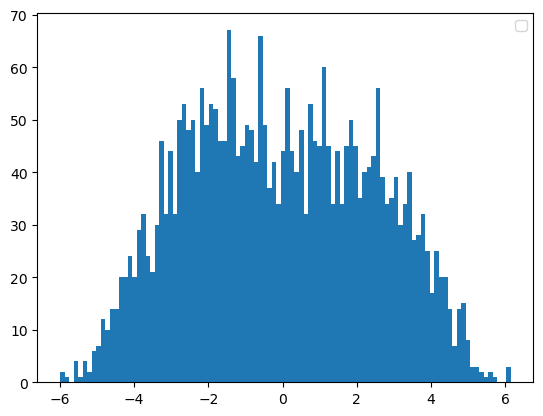

In [ ]:
import matplotlib.pyplot as plt

plt.hist(r[0][:, :2].reshape(-1), bins=100)
plt.legend()
plt.show()

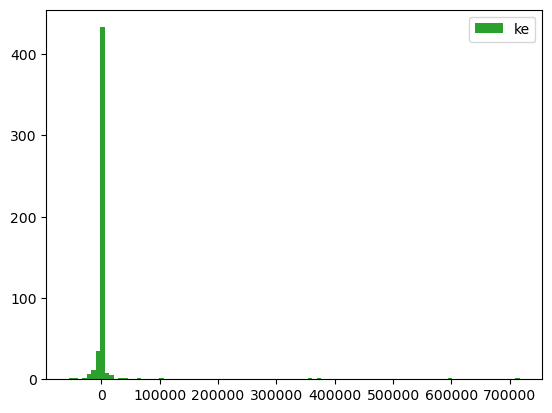

In [ ]:
import matplotlib.pyplot as plt

plt.hist(e, bins=100)
plt.hist(pe, bins=100)
plt.hist(ke, bins=100, label='ke')
plt.legend()
plt.show()

In [ ]:

def create_train_state_i(rng, r):
    model = c.partial(FermiNet)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))

state = create_train_state_i(rng, r[0])

deltar_i = deltar[0]
r_0 = r[0]


p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)

for _ in jnp.arange(1, c.data.corr_len):
	rng, rng_alpha = rnd.split(rng, 2)

	r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*deltar_i
	p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2

	p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
	
	p_0 = jnp.where(p_mask, p_1, p_0)
	r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)	
	print(p_mask.mean())



0.8222656
0.8144531
0.78515625
0.8105469
0.8183594
0.78125
0.8066406
0.8261719
0.8417969


In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
from jax import vmap

@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
def create_train_state(rng, r):
    model = c.partial(FermiNet, with_sign=True)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))
    
state = create_train_state(rng, r)

@partial(vmap, in_axes=(0, None, None))
def swap_rows(r, i_0, i_1):
    return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

@partial(pmap, in_axes=(0, 0))
def check_antisym(state, r):
    log_psi_0, sgn_0 = state.apply_fn(state.params, r)
    r_swap_u = swap_rows(r, 0, 1)
    log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
    log_psi_d = jnp.zeros_like(log_psi_0)
    sgn_d = jnp.zeros_like(sgn_0)
    if not c.data.n_d == 0:
        r_swap_d = swap_rows(r, c.data.n_u, c.data.n_u+1)
        log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
    return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

res = check_antisym(state, r)

(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
    print(ei, ej, ek)  # Swap Correct
for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct
for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct

ValueError: pmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 2: axis 0 of argument rng of type uint32[2];
  * one axis had size 1: axis 0 of argument r of type float32[1,512,4,3]

In [ ]:
from jax import vmap

def check_antisym(c, rng, r):
	n_u, n_d, = c.data.n_u, c.data.n_d
	r = r[:, :4]
	
	@partial(vmap, in_axes=(0, None, None))
	def swap_rows(r, i_0, i_1):
		return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

	@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
	def _create_train_state(rng, r):
		model = c.partial(FermiNet, with_sign=True)  
		params = model.init(rng, r)['params']
		return TrainState.create(apply_fn=model.apply, params=params, tx=c.opt.tx)
	
	state = _create_train_state(rng, r)

	@partial(pmap, in_axes=(0, 0))
	def _check_antisym(state, r):
		log_psi_0, sgn_0 = state.apply_fn(state.params, r)
		r_swap_u = swap_rows(r, 0, 1)
		log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
		log_psi_d = jnp.zeros_like(log_psi_0)
		sgn_d = jnp.zeros_like(sgn_0)
		if not n_d == 0:
			r_swap_d = swap_rows(r, n_u, n_u+1)
			log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
		return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

	res = _check_antisym(state, r)

	(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
	for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
		print(ei, ej, ek)  # Swap Correct
	for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct
	for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct

In [ ]:

state.params['params']



FrozenDict({
    Dense_0: {
        bias: ShardedDeviceArray([[0.01459372, 0.00997529, 0.01267799, 0.0786592 ,
                             0.04518591, 0.01598902, 0.01946411, 0.0160135 ,
                             0.0820886 , 0.066571  , 0.07754244, 0.05884545,
                             0.076667  , 0.0361336 , 0.01449547, 0.03578294,
                             0.02859007, 0.06440564, 0.09925729, 0.07102094,
                             0.07148563, 0.06547641, 0.04870448, 0.03848153,
                             0.06832297, 0.02668134, 0.02206043, 0.09556375,
                             0.04705796, 0.07842465, 0.04566721, 0.04030572]],                   dtype=float32),
        kernel: ShardedDeviceArray([[[ 2.69128174e-01, -5.06307244e-01,  1.86619103e-01,
                              -2.58631647e-01,  2.83852220e-01, -8.21515843e-02,
                              -3.84322810e-03, -3.50300491e-01, -4.67570461e-02,
                               2.10296005e-01, -4.19384778e-01,